# Air Pollution forecasting for CDMX
_Authors: Ahumada, D. & Guerrero, J._

The following project 

In [40]:
!pip install geopandas
!pip uninstall rtree -y
!sudo apt install libspatialindex-dev
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 36.4 MB/s 
     |████████████████████████████████| 16.7 MB 35.1 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 42 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archiv

In [21]:
from typing import Callable

In [41]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import numpy as np
from os import path
import geopandas as gpd

## Data Collection

### Data Sources

In [39]:
def load_dataset(file: str, func: Callable[[], pd.DataFrame]) -> pd.DataFrame:
  if path.exists(file):
    return pd.read_csv(file, index_col=0)
  df = func()
  df.to_csv(file)
  return df

In [3]:
def print_head(src: str, n: int):
  res = requests.get(src)
  lines = res.text.splitlines()
  for i in range(n):
    print(lines[i])


In [4]:
def id_parameters_to_cols(df: pd.DataFrame):
  cols = df['id_parameter'].unique()
  df = df.pivot_table('value', ['date', 'id_station'], 'id_parameter')
  df.reset_index( drop=False, inplace=True )
  df = df.reindex(['date', 'id_station'] + [ a for a in cols], axis=1)
  return df

In [12]:
def parse_date(x: str, format: str='%d/%m/%Y %H:%M'):
  has_24 = x.endswith("24:00")
  if has_24:
    x = x.replace("24:00", "00:00")
  dt = datetime.strptime(x, format)
  if has_24:
    dt = dt + timedelta(days=1)  
  return dt

parse_date("01/01/2022 24:00")

datetime.datetime(2022, 1, 2, 0, 0)

In [13]:
def get_date_range(dates: pd.Series, ):
  dates = dates.apply(parse_date)
  return dates.min(), dates.max()

#### Meteorology

In [5]:
print_head("http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/meteorología_2022.csv", 12)

Pollutants
city: Ciudad de M&eacute;xico
cityCode: MEX
country: M&eacute;xico
mesurementAgency: SIMAT
URL: http://www.aire.cdmx.gob.mx
timeStamp: 2022/01/01 al 2022/12/31
average_interval: 001h
version:DT001-IAD-20220518-142921
key: M-TUF48-M4TSI-DM8VN-LQIXE	
date,id_station,id_parameter,value,unit
01/01/2022 01:00,ACO,RH,71,6


In [25]:
def fetch_db_meteorologia(anio: str):
  df = pd.read_csv(
      f"http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/meteorolog%C3%ADa_{anio}.csv",
      encoding="latin1",
      skiprows=10
  )
  return df[df["id_parameter"] != "PBa"]

In [71]:
def _fetch_meteorology():
  df_meteorologia = fetch_db_meteorologia("2018")
  for i in ["2019", "2020", "2021", "2022"]:
    df_meteorologia = df_meteorologia.append(fetch_db_meteorologia(i), ignore_index=True)
  # Group parameters in same row for each station for each date
  df_meteorologia_h = id_parameters_to_cols(df_meteorologia)
  return df_meteorologia_h
df_meteorologia_h = load_dataset("meteorology.csv", _fetch_meteorology)

In [72]:
get_date_range(df_meteorologia_h["date"])

(Timestamp('2018-01-01 01:00:00'), Timestamp('2022-05-01 00:00:00'))

In [73]:
df_meteorologia_h.head()

,date,id_station,RH,TMP,WDR,WSP
0,01/01/2018 01:00,ACO,52.0,11.3,25.0,2.5
1,01/01/2018 01:00,AJM,53.0,11.6,258.0,1.8
2,01/01/2018 01:00,AJU,91.0,2.2,194.0,1.9
3,01/01/2018 01:00,BJU,47.0,14.2,308.0,1.6
4,01/01/2018 01:00,CHO,59.0,10.2,157.0,0.5


#### Pollutants

In [35]:
print_head("http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/contaminantes_2022.csv", 12)

Pollutants
city: Ciudad de M&eacute;xico
cityCode: MEX
country: M&eacute;xico
mesurementAgency: SIMAT
URL: http://www.aire.cdmx.gob.mx
timeStamp: 2022/01/01 al 2022/12/31
average_interval: 001h
version:DT001-IAD-20220518-142921
key: M-0TO1C-MV6D8-YWDJW-R1V7V	
date,id_station,id_parameter,value,unit
01/01/2022 01:00,ACO,CO,1.1,15


In [36]:
def fetch_db_contaminantes(anio: str):
  return pd.read_csv(
      f"http://www.aire.cdmx.gob.mx/opendata/anuales_horarios/contaminantes_{anio}.csv",
      encoding="latin1",
      skiprows=10
  )

In [48]:
def _fetch_pollutants():
  df_contaminantes = fetch_db_contaminantes("2018")
  for i in ["2019", "2020", "2021", "2022"]:
    df_contaminantes = df_contaminantes.append(fetch_db_contaminantes(i), ignore_index=True)
  # Group parameters in same row for each station for each date
  df_contaminantes = id_parameters_to_cols(df_contaminantes)
  return df_contaminantes
df_contaminantes = load_dataset("pollutants.csv", _fetch_pollutants)

In [49]:
df_contaminantes = id_parameters_to_cols(df_contaminantes)
df_contaminantes.to_csv("pollutants.csv")

In [50]:
get_date_range(df_contaminantes["date"])

(Timestamp('2018-01-01 01:00:00'), Timestamp('2022-05-01 00:00:00'))

#### Estaciones

In [51]:
print_head("http://www.aire.cdmx.gob.mx/opendata/catalogos/cat_estacion.csv", 12)

Catalogo de estaciones,,,,,,
cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station
ACO,Acolman,-98.912003,19.635501,2198,,484150020109
AJU,Ajusco,-99.162611,19.154286,2942,,484090120400
AJM,Ajusco Medio,-99.207744,19.272161,2548,,484090120609
ARA,Aragón,-99.074549,19.470218,2200,Finalizó operación en 2010,484090050301
ATI,Atizapan,-99.254133,19.576963,2341,,484150130101
AZC,Azcapotzalco,-99.198657,19.487728,2279,Finalizó operación en 2010,484090020201
BJU,Benito Juárez,-99.159596,19.370464,2249,Finalizó operación en 2005,484090140201
CAM,Camarones,-99.169794,19.468404,2233,,484090020301
CCA,Centro de Ciencias de la Atmósfera,-99.176111,19.326111,2294,,484090030501
CES,Cerro de la Estrella,-99.074678,19.334731,2219,Finalizó operación en 2010,484090070111


In [52]:
df_estaciones = pd.read_csv(
    "http://www.aire.cdmx.gob.mx/opendata/catalogos/cat_estacion.csv",
     encoding="latin1",
    skiprows=1
)

In [53]:
df_estaciones.head()

,cve_estac,nom_estac,longitud,latitud,alt,obs_estac,id_station
0,ACO,Acolman,-98.912003,19.635501,2198.0,NaN,484150020109
1,AJU,Ajusco,-99.162611,19.154286,2942.0,NaN,484090120400
2,AJM,Ajusco Medio,-99.207744,19.272161,2548.0,NaN,484090120609
3,ARA,Aragón,-99.074549,19.470218,2200.0,Finalizó operación en 2010,484090050301
4,ATI,Atizapan,-99.254133,19.576963,2341.0,NaN,484150130101


In [157]:
df_aire = pd.merge(df_contaminantes, df_meteorologia_h, on=["id_station", "date"])
df_aire.head()

,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,01/01/2018 01:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,01/01/2018 01:00,AJM,0.8,2.0,25.0,26.0,31.0,92.0,6.0,65.0,27.0,53.0,11.6,258.0,1.8
2,01/01/2018 01:00,AJU,NaN,NaN,NaN,NaN,17.0,NaN,NaN,49.0,NaN,91.0,2.2,194.0,1.9
3,01/01/2018 01:00,BJU,0.6,NaN,NaN,NaN,22.0,78.0,9.0,56.0,22.0,47.0,14.2,308.0,1.6
4,01/01/2018 01:00,CUA,0.5,4.0,31.0,34.0,16.0,137.0,11.0,NaN,NaN,56.0,10.6,340.0,1.4


In [158]:
df_aire = pd.merge(
    df_estaciones[["cve_estac", "nom_estac", "longitud", "latitud"]],
    df_aire,
    left_on="cve_estac",
    right_on="id_station",
    how='inner'
)

In [76]:
df_aire.head()

,cve_estac,nom_estac,longitud,latitud,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,ACO,Acolman,-98.912003,19.635501,01/01/2018 01:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,ACO,Acolman,-98.912003,19.635501,01/01/2018 02:00,ACO,0.4,2.0,19.0,21.0,13.0,98.0,3.0,NaN,NaN,52.0,10.6,359.0,1.7
2,ACO,Acolman,-98.912003,19.635501,01/01/2018 03:00,ACO,0.4,2.0,15.0,17.0,15.0,88.0,3.0,NaN,NaN,53.0,9.9,347.0,2.5
3,ACO,Acolman,-98.912003,19.635501,01/01/2018 04:00,ACO,0.4,2.0,14.0,15.0,20.0,82.0,3.0,NaN,NaN,53.0,9.4,330.0,2.7
4,ACO,Acolman,-98.912003,19.635501,01/01/2018 05:00,ACO,0.4,2.0,14.0,16.0,16.0,96.0,4.0,NaN,NaN,60.0,7.5,319.0,2.5


In [77]:
df_aire.to_csv("df_aire.csv")

In [78]:
!ls -las

total 205564
    4 drwxr-xr-x 1 root root     4096 May 24 20:34 .
    4 drwxr-xr-x 1 root root     4096 May 24 19:56 ..
    4 drwxr-xr-x 4 root root     4096 May 17 13:38 .config
91192 -rw-r--r-- 1 root root 93379308 May 24 20:40 df_aire.csv
    4 drwxr-xr-x 2 root root     4096 May 24 20:34 mapa_mexico
11076 -rw-r--r-- 1 root root 11337915 Mar 23  2021 mapa_mexico.zip
42520 -rw-r--r-- 1 root root 43536664 May 24 20:36 meteorology.csv
60756 -rw-r--r-- 1 root root 62210082 May 24 20:33 pollutants.csv
    4 drwxr-xr-x 1 root root     4096 May 17 13:39 sample_data


#### Mapas de México

In [59]:
!wget "http://jjsantoso.com/blog/datos/mapa_mexico.zip"
!unzip mapa_mexico.zip

--2022-05-24 20:34:23--  http://jjsantoso.com/blog/datos/mapa_mexico.zip
Resolving jjsantoso.com (jjsantoso.com)... 52.219.108.48
Connecting to jjsantoso.com (jjsantoso.com)|52.219.108.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11337915 (11M) [application/zip]
Saving to: ‘mapa_mexico.zip’

mapa_mexico.zip     100%[===================>]  10.81M  5.95MB/s    in 1.8s    

2022-05-24 20:34:26 (5.95 MB/s) - ‘mapa_mexico.zip’ saved [11337915/11337915]

Archive:  mapa_mexico.zip
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.dbf  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.prj  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.sbn  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.sbx  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.shp  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.shp.xml  
  inflating: mapa_mexico/Division_Municipal_Mexico_2010.shx  


In [60]:
gdf_mx = gpd.read_file('mapa_mexico/')

In [61]:
gdf_mx.drop_duplicates(subset = ["CVE_EDO"])

,CLAVE,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
0,02004,Tijuana,Baja California,02,004,1122.661145,"POLYGON ((-117.09481 32.41141, -117.09481 32.4..."
4,26055,San Luis Rio Colorado,Sonora,26,055,9033.770278,"POLYGON ((-114.96166 32.36465, -114.96239 32.3..."
10,08005,Ascension,Chihuahua,08,005,12980.720491,"POLYGON ((-108.20803 31.33335, -108.20804 31.4..."
66,05002,Acuña,Coahuila,05,002,11493.631607,"POLYGON ((-102.28642 29.87223, -102.28515 29.8..."
112,03002,Mulege,Baja California Sur,03,002,31772.313354,"POLYGON ((-112.76431 28.00001, -112.76177 27.9..."
138,19005,Anahuac,Nuevo Leon,19,005,4514.176154,"POLYGON ((-99.83317 27.76236, -99.83024 27.762..."
145,28027,Nuevo Laredo,Tamaulipas,28,027,1212.778180,"POLYGON ((-99.72785 27.67892, -99.72543 27.675..."
165,25007,Choix,Sinaloa,25,007,3185.953784,"POLYGON ((-108.30306 27.03613, -108.30281 27.0..."
180,10017,Ocampo,Durango,10,017,3597.863507,"POLYGON ((-105.97007 26.79002, -105.96991 26.7..."
279,32027,Melchor Ocampo,Zacatecas,32,027,1952.458047,"POLYGON ((-102.45856 25.11611, -102.45802 25.1..."


In [62]:
gdf_cdmx = gdf_mx[gdf_mx["CVE_EDO"] == "09"] # Get only municipalities at Mexico City

In [79]:
gdf_cdmx.head()

,CLAVE,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry
1162,09005,Gustavo A. Madero,D.F.,09,005,87.445402,"POLYGON ((-99.11705 19.58909, -99.11748 19.588..."
1195,09002,Azcapotzalco,D.F.,09,002,33.420781,"POLYGON ((-99.15688 19.50231, -99.15684 19.502..."
1214,09016,Miguel Hidalgo,D.F.,09,016,45.938498,"POLYGON ((-99.20666 19.47052, -99.20610 19.470..."
1218,09015,Cuauhtemoc,D.F.,09,015,32.383814,"POLYGON ((-99.14274 19.46446, -99.14243 19.464..."
1223,09017,Venustiano Carranza,D.F.,09,017,33.599971,"POLYGON ((-99.05068 19.44927, -99.04696 19.440..."


In [80]:
#join dataframes to do a geospatial visualization with the distribution of the meteorological stations
df_temp = df_aire.drop_duplicates(subset = ["id_station"])
df_temp = df_temp[["cve_estac", "nom_estac",	"longitud", "latitud", "id_station"]]
gdf_estaciones = gpd.GeoDataFrame(df_temp, geometry=gpd.points_from_xy(df_temp.longitud, df_temp.latitud))
gdf_estaciones.head(2)

,cve_estac,nom_estac,longitud,latitud,id_station,geometry
0,ACO,Acolman,-98.912003,19.635501,ACO,POINT (-98.91200 19.63550)
25988,AJU,Ajusco,-99.162611,19.154286,AJU,POINT (-99.16261 19.15429)


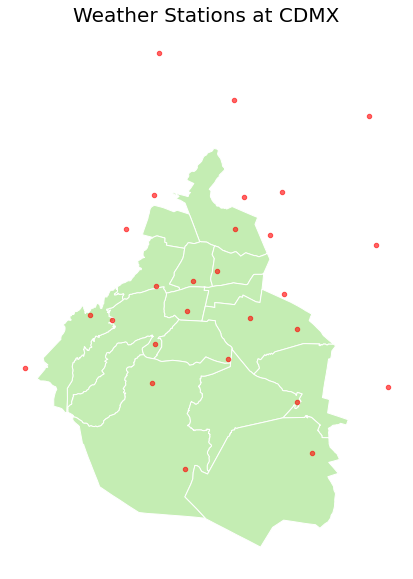

In [88]:
ax =gdf_cdmx.plot(color="#c4edb3", edgecolor='white', figsize=(10,10))
ax.set_title("Weather Stations at CDMX", fontsize=20)
ax.axis('off')
gdf_estaciones.plot(ax=ax, color='red',markersize=20, alpha=0.6)

### Handle null values

In [136]:
def create_df_nan(df: pd.DataFrame, grouping_col: str = "id_station"):
  df_nan = df.copy()
  df_nan["__aux"] = df_nan[grouping_col]
  df_nan = df_nan.groupby(grouping_col).count() #Cuenta cantidad de lecturas no nulos por estación
  cols = df_nan.select_dtypes(include=np.number).columns.tolist()
  for col in cols:
    if col == '__aux':
      continue
    df_nan[col] = df_nan["__aux"] - df_nan[col]
  return df_nan.sum(axis=1) / ((len(df_nan.columns)*df_nan["__aux"]) - 5)*100

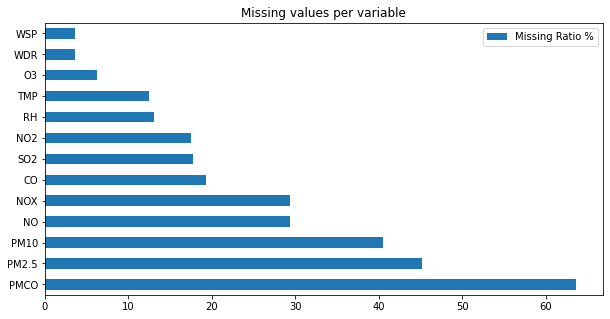

In [159]:
def plot_missing_per_variable(df: pd.DataFrame):
  na_df = (df.isnull().sum() / len(df)) * 100      
  na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
  missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
  missing_data.plot(kind = "barh", figsize=(10,5), title="Missing values per variable")

plot_missing_per_variable(df_aire)

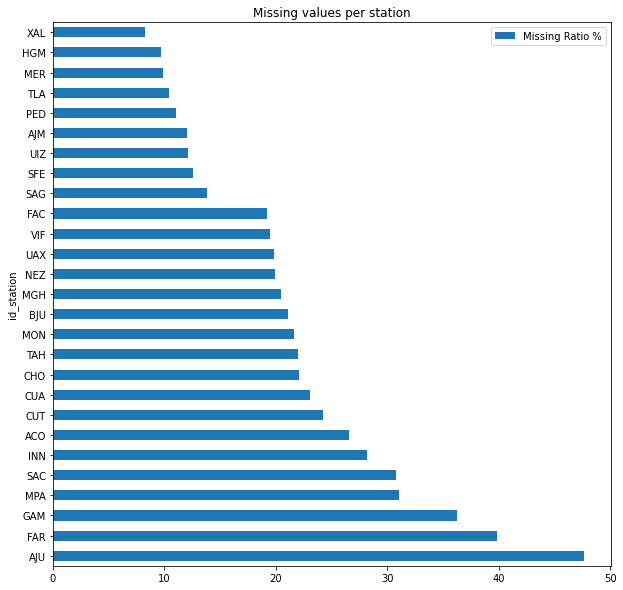

In [160]:
def plot_missing_per_station(df: pd.DataFrame):
  na_df = create_df_nan(df).sort_values(ascending=False)
  missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
  missing_data.plot(kind = "barh", figsize=(10,10), title="Missing values per station")

plot_missing_per_station(df_aire)

#### Fill empty with the value of the previous hour

In [161]:
df_aire["date"] = df_aire["date"].apply(parse_date)
df_aire.head()

,cve_estac,nom_estac,longitud,latitud,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,ACO,Acolman,-98.912003,19.635501,2018-01-01 01:00:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,ACO,Acolman,-98.912003,19.635501,2018-01-01 02:00:00,ACO,0.4,2.0,19.0,21.0,13.0,98.0,3.0,NaN,NaN,52.0,10.6,359.0,1.7
2,ACO,Acolman,-98.912003,19.635501,2018-01-01 03:00:00,ACO,0.4,2.0,15.0,17.0,15.0,88.0,3.0,NaN,NaN,53.0,9.9,347.0,2.5
3,ACO,Acolman,-98.912003,19.635501,2018-01-01 04:00:00,ACO,0.4,2.0,14.0,15.0,20.0,82.0,3.0,NaN,NaN,53.0,9.4,330.0,2.7
4,ACO,Acolman,-98.912003,19.635501,2018-01-01 05:00:00,ACO,0.4,2.0,14.0,16.0,16.0,96.0,4.0,NaN,NaN,60.0,7.5,319.0,2.5


In [162]:
df_aire_time = df_aire.sort_values(by=["cve_estac", "date"])
#Max delta of 12 hours
df_aire_time = df_aire_time.groupby(by="cve_estac", as_index=False).fillna(method="ffill", limit=12) 
df_aire_time.head()

,nom_estac,longitud,latitud,date,id_station,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP
0,Acolman,-98.912003,19.635501,2018-01-01 01:00:00,ACO,0.4,3.0,23.0,25.0,8.0,125.0,2.0,NaN,NaN,52.0,11.3,25.0,2.5
1,Acolman,-98.912003,19.635501,2018-01-01 02:00:00,ACO,0.4,2.0,19.0,21.0,13.0,98.0,3.0,NaN,NaN,52.0,10.6,359.0,1.7
2,Acolman,-98.912003,19.635501,2018-01-01 03:00:00,ACO,0.4,2.0,15.0,17.0,15.0,88.0,3.0,NaN,NaN,53.0,9.9,347.0,2.5
3,Acolman,-98.912003,19.635501,2018-01-01 04:00:00,ACO,0.4,2.0,14.0,15.0,20.0,82.0,3.0,NaN,NaN,53.0,9.4,330.0,2.7
4,Acolman,-98.912003,19.635501,2018-01-01 05:00:00,ACO,0.4,2.0,14.0,16.0,16.0,96.0,4.0,NaN,NaN,60.0,7.5,319.0,2.5


In [163]:
df_aire_time.columns

Index(['nom_estac', 'longitud', 'latitud', 'date', 'id_station', 'CO', 'NO',
       'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'PM2.5', 'PMCO', 'RH', 'TMP', 'WDR',
       'WSP'],
      dtype='object')

In [164]:
features = [
  'CO', 'NO',
  'NO2', 'NOX', 'O3', 'PM10', 'SO2', 'PM2.5', 'PMCO', 'RH', 'TMP', 'WDR',
  'WSP',
]

In [165]:
df_aire_time = df_aire_time.groupby([df_aire_time.id_station, df_aire_time.date.dt.date])[features].agg(['mean', 'var']).reset_index()

In [166]:
df_aire_daily = df_aire_time[['id_station','date']]

In [167]:
df_aire_daily.columns = df_aire_daily.columns.droplevel(level=1)

In [168]:
for feature in features:
  df_aire_daily[feature] = df_aire_time[feature]["mean"]
# Adds PM10 variance to keep data from the daily behavor when grouping by day
df_aire_daily["PM10_var"] = df_aire_time["PM10"]["var"]
features += ["PM10_var"]
df_aire_daily

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,id_station,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var
0,ACO,2018-01-01,0.243478,2.000000,12.782609,14.652174,14.652174,55.739130,1.608696,NaN,NaN,55.739130,11.600000,199.391304,3.173913,928.292490
1,ACO,2018-01-02,0.308333,7.833333,17.833333,25.666667,9.250000,50.958333,1.125000,NaN,NaN,61.208333,11.333333,203.125000,1.533333,833.346014
2,ACO,2018-01-03,0.366667,14.000000,20.833333,34.875000,15.250000,70.583333,2.375000,NaN,NaN,57.083333,12.762500,246.625000,2.087500,284.688406
3,ACO,2018-01-04,0.383333,14.916667,26.958333,41.750000,12.250000,79.208333,3.583333,NaN,NaN,59.291667,11.937500,239.500000,1.654167,596.780797
4,ACO,2018-01-05,0.343478,7.956522,22.130435,30.086957,13.782609,78.434783,3.391304,NaN,NaN,50.956522,14.473913,183.739130,1.804348,510.438735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34532,XAL,2019-12-28,0.850000,47.727273,38.727273,86.590909,17.818182,NaN,3.000000,NaN,NaN,46.636364,16.709091,156.500000,2.477273,NaN
34533,XAL,2019-12-29,0.954167,47.666667,31.875000,79.708333,10.250000,NaN,2.958333,NaN,NaN,49.541667,15.379167,214.083333,1.841667,NaN
34534,XAL,2019-12-30,0.829167,64.916667,27.791667,92.541667,10.916667,NaN,2.916667,NaN,NaN,42.708333,16.929167,116.958333,2.679167,NaN
34535,XAL,2019-12-31,0.912500,48.958333,31.666667,80.708333,19.958333,NaN,4.958333,NaN,NaN,44.916667,16.966667,88.625000,1.866667,NaN


### K-means to group by geographical regions

In [171]:
from sklearn import preprocessing, cluster
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.cluster.vq import vq

In [172]:
gdf_estaciones.head()

,cve_estac,nom_estac,longitud,latitud,id_station,geometry
0,ACO,Acolman,-98.912003,19.635501,ACO,POINT (-98.91200 19.63550)
25988,AJU,Ajusco,-99.162611,19.154286,AJU,POINT (-99.16261 19.15429)
48741,AJM,Ajusco Medio,-99.207744,19.272161,AJM,POINT (-99.20774 19.27216)
69867,BJU,Benito Juárez,-99.159596,19.370464,BJU,POINT (-99.15960 19.37046)
105578,CHO,Chalco,-98.886088,19.266948,CHO,POINT (-98.88609 19.26695)


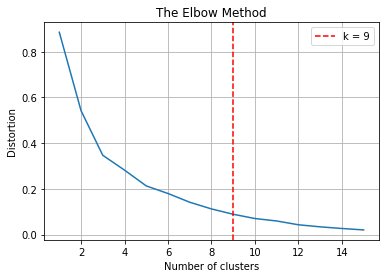

In [173]:
X = gdf_estaciones[["latitud","longitud"]]
max_k = 15
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [174]:
k = 9

In [283]:
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = gdf_estaciones[["latitud","longitud"]]
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

## find the centroids
closest, distances = vq(model.cluster_centers_, 
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1

gdf_estaciones[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
gdf_estaciones.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,cve_estac,nom_estac,longitud,latitud,id_station,geometry,cluster,centroids,color
0,ACO,Acolman,-98.912003,19.635501,ACO,POINT (-98.91200 19.63550),4,1,"[94.65599999999999, 86.69999999999999, 219.299..."
25988,AJU,Ajusco,-99.162611,19.154286,AJU,POINT (-99.16261 19.15429),7,1,"[219.29999999999998, 86.69999999999999, 167.14..."
48741,AJM,Ajusco Medio,-99.207744,19.272161,AJM,POINT (-99.20774 19.27216),2,0,"[86.69999999999999, 219.29999999999998, 94.655..."
69867,BJU,Benito Juárez,-99.159596,19.370464,BJU,POINT (-99.15960 19.37046),0,0,"[86.69999999999999, 219.29999999999998, 94.655..."
105578,CHO,Chalco,-98.886088,19.266948,CHO,POINT (-98.88609 19.26695),1,0,"[86.69999999999999, 167.14399999999995, 219.29..."


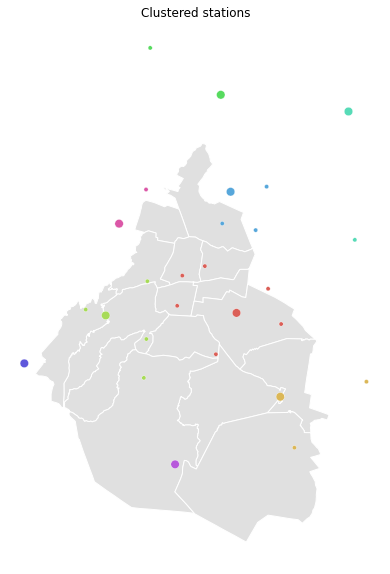

In [285]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
ax.axis('off')
ax.set_title("Clustered stations")
gdf_cdmx.plot(ax=ax, color='#e0e0e0', edgecolor='white', figsize=(10,10))
sns.scatterplot(
    x="longitud",
    y="latitud",
    data=gdf_estaciones, 
    palette=sns.color_palette("hls",k),
    hue='cluster', size="centroids", size_order=[1,0],
    legend=False, ax=ax,
)

##### Group municipalities by cluster

In [286]:
df_alcaldias = pd.read_csv('alcaldias.csv')
df_alcaldias["latitud"] = df_alcaldias["geo_point_2d"].apply(lambda x: x.split(",")[0])
df_alcaldias["longitud"] = df_alcaldias["geo_point_2d"].apply(lambda x: x.split(",")[1])
df_alcaldias.head()

,id,nomgeo,cve_mun,cve_ent,cvegeo,geo_point_2d,geo_shape,municipio,latitud,longitud
0,0,Milpa Alta,9,9,9009,"19.1394565999,-99.0510954218","{""type"": ""Polygon"", ""coordinates"": [[[-98.9972...",9,19.1394565999,-99.0510954218
1,1,Benito Juárez,14,9,9014,"19.3806424162,-99.1611346584","{""type"": ""Polygon"", ""coordinates"": [[[-99.1367...",14,19.3806424162,-99.1611346584
2,2,Gustavo A. Madero,5,9,9005,"19.5040652077,-99.1158642087","{""type"": ""Polygon"", ""coordinates"": [[[-99.1185...",5,19.5040652077,-99.1158642087
3,3,Coyoacán,3,9,9003,"19.3266672536,-99.1503763525","{""type"": ""Polygon"", ""coordinates"": [[[-99.1392...",3,19.3266672536,-99.1503763525
4,4,Miguel Hidalgo,16,9,9016,"19.4280623649,-99.2045669144","{""type"": ""Polygon"", ""coordinates"": [[[-99.1905...",16,19.4280623649,-99.2045669144


In [287]:
X = df_alcaldias[["latitud","longitud"]]
dtf_X = X.copy()
dtf_X["cluster"] = model.predict(X)
df_alcaldias[["cluster"]] = dtf_X[["cluster"]]
df_alcaldias = gpd.GeoDataFrame(df_alcaldias[["latitud", "longitud", "cluster"]], geometry=gpd.points_from_xy(df_alcaldias.longitud, df_alcaldias.latitud))
df_alcaldias.head()

,latitud,longitud,cluster,geometry
0,19.1394565999,-99.0510954218,7,POINT (-99.05110 19.13946)
1,19.3806424162,-99.1611346584,0,POINT (-99.16113 19.38064)
2,19.5040652077,-99.1158642087,5,POINT (-99.11586 19.50407)
3,19.3266672536,-99.1503763525,0,POINT (-99.15038 19.32667)
4,19.4280623649,-99.2045669144,8,POINT (-99.20457 19.42806)


In [288]:
gdf_cdmx_con_cluster = gdf_cdmx.sjoin(df_alcaldias, how="inner")
gdf_cdmx_con_cluster

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


,CLAVE,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry,index_right,latitud,longitud,cluster
1162,09005,Gustavo A. Madero,D.F.,09,005,87.445402,"POLYGON ((-99.11705 19.58909, -99.11748 19.588...",2,19.5040652077,-99.1158642087,5
1195,09002,Azcapotzalco,D.F.,09,002,33.420781,"POLYGON ((-99.15688 19.50231, -99.15684 19.502...",7,19.4853286147,-99.1821069423,8
1214,09016,Miguel Hidalgo,D.F.,09,016,45.938498,"POLYGON ((-99.20666 19.47052, -99.20610 19.470...",4,19.4280623649,-99.2045669144,8
1218,09015,Cuauhtemoc,D.F.,09,015,32.383814,"POLYGON ((-99.14274 19.46446, -99.14243 19.464...",14,19.4313734294,-99.1490557562,0
1223,09017,Venustiano Carranza,D.F.,09,017,33.599971,"POLYGON ((-99.05068 19.44927, -99.04696 19.440...",11,19.4304954545,-99.0931057959,0
1244,09006,Iztacalco,D.F.,09,006,23.123819,"POLYGON ((-99.12534 19.40359, -99.12184 19.404...",8,19.396911897,-99.094329797,0
1251,09014,Benito Juarez,D.F.,09,014,26.400780,"POLYGON ((-99.13543 19.40262, -99.13557 19.402...",1,19.3806424162,-99.1611346584,0
1252,09010,Alvaro Obregon,D.F.,09,010,95.434621,"POLYGON ((-99.24694 19.38558, -99.24584 19.386...",9,19.336175562,-99.246819712,2
1253,09004,Cuajimalpa de Morelos,D.F.,09,004,70.047016,"POLYGON ((-99.25510 19.40213, -99.25499 19.401...",13,19.3246343001,-99.3107285253,6
1254,09007,Iztapalapa,D.F.,09,007,113.106540,"POLYGON ((-99.05769 19.39993, -99.03938 19.391...",15,19.3491663204,-99.0567989642,0


In [289]:
gdf_cdmx_con_cluster["color"] = gdf_cdmx_con_cluster["cluster"].apply(lambda x: colors[x])
gdf_cdmx_con_cluster.head(2)

,CLAVE,NOM_MUN,NOMEDO,CVE_EDO,CVE_MUNI,Area,geometry,index_right,latitud,longitud,cluster,color
1162,09005,Gustavo A. Madero,D.F.,09,005,87.445402,"POLYGON ((-99.11705 19.58909, -99.11748 19.588...",2,19.5040652077,-99.1158642087,5,#56a7db
1195,09002,Azcapotzalco,D.F.,09,002,33.420781,"POLYGON ((-99.15688 19.50231, -99.15684 19.502...",7,19.4853286147,-99.1821069423,8,#db56a7


In [290]:
colors = np.array(*[sns.color_palette("hls",k)])*255
colors = ["#"+"".join([f'{hex(int(i))[2:]}0'[:2] for i in c]) for c in colors]
colors

['#db5e56',
 '#dbb756',
 '#a7db56',
 '#56db5e',
 '#56dbb7',
 '#56a7db',
 '#5e56db',
 '#b756db',
 '#db56a7']

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


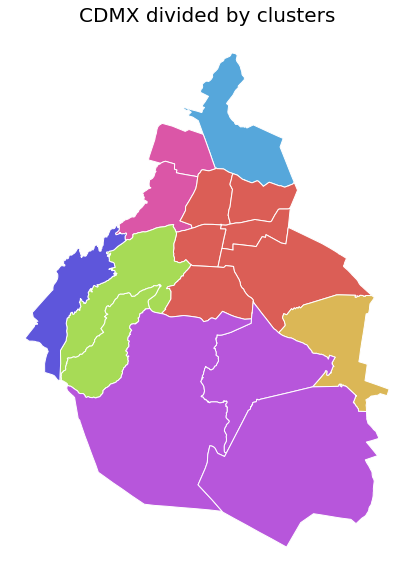

In [291]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
ax.axis('off')
ax.set_title("CDMX divided by clusters", fontsize=20)
gdf_cdmx_con_cluster.plot(ax=ax, column="cluster", color=gdf_cdmx_con_cluster["color"], edgecolor='white', figsize=(10,10))

In [310]:
gdf_cdmx_con_cluster.to_csv("cdmx_by_cluster.csv")

##### Join observations by cluster

In [294]:
df_aire_clustered = df_aire_daily.merge(gdf_estaciones, on="id_station", how='inner')
df_aire_clustered = df_aire_clustered.groupby([df_aire_clustered.cluster, df_aire_clustered.date])[features].mean().reset_index()

In [295]:
df_aire_clustered.head(2)

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var
0,0,2018-01-01,0.447826,5.978261,22.391304,28.380435,26.713043,67.855072,19.165217,52.173913,20.376812,52.471014,13.300000,219.804348,2.285507,541.783926
1,0,2018-01-02,0.561458,19.250000,29.416667,48.635417,22.166667,44.444444,4.000000,25.275000,20.791667,56.138889,13.013889,146.381944,1.496528,471.623188


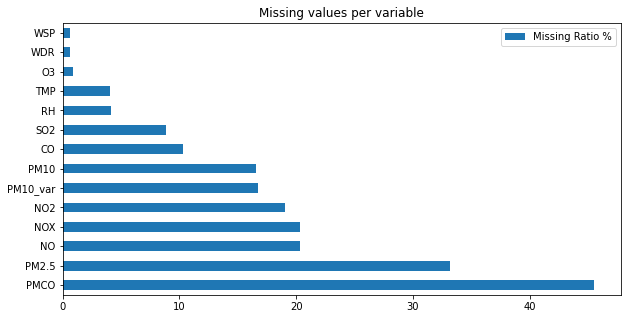

In [297]:
plot_missing_per_variable(df_aire_clustered)

#### If a cluster has NaN, use the daily summary

In [298]:
df_aire_daily_summary = df_aire_clustered.groupby("date").mean().reset_index()
df_aire_daily_summary = df_aire_daily_summary.add_prefix('daily_')
df_aire_daily_summary["date"] = df_aire_daily_summary["daily_date"]
df_aire_daily_summary

,daily_date,daily_cluster,daily_CO,daily_NO,daily_NO2,daily_NOX,daily_O3,daily_PM10,daily_SO2,daily_PM2.5,daily_PMCO,daily_RH,daily_TMP,daily_WDR,daily_WSP,daily_PM10_var,date
0,2018-01-01,4.0,0.385343,5.168379,18.281564,23.470130,30.819697,64.829093,13.472184,44.388889,20.184058,59.480420,11.434310,197.674235,2.214644,1223.967879,2018-01-01
1,2018-01-02,4.0,0.457180,21.136039,24.394805,45.545157,26.261181,49.823193,3.508570,24.884638,23.277652,62.526627,11.307652,168.937332,1.561829,929.462834,2018-01-02
2,2018-01-03,4.0,0.525271,25.214801,31.553499,56.747046,31.291083,69.453548,9.098240,33.513029,35.427381,57.197186,12.907638,174.616738,1.769829,832.444769,2018-01-03
3,2018-01-04,4.0,0.513771,25.612679,35.089385,60.675298,31.252901,72.612500,17.062743,38.926124,32.349815,61.857702,11.860819,157.918649,1.610830,707.866956,2018-01-04
4,2018-01-05,4.0,0.517426,19.326872,33.590148,52.937502,34.862677,73.254092,7.190744,40.729523,35.325022,55.685716,14.106998,165.887125,1.682568,641.147534,2018-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1577,2022-04-27,4.0,0.225423,5.950399,13.970563,20.234452,35.603923,24.703677,1.314326,10.260590,12.996086,58.431619,15.516833,188.989259,2.267463,152.530711,2022-04-27
1578,2022-04-28,4.0,0.387201,14.907738,20.633816,35.787698,40.456559,31.445887,1.766202,15.289162,11.855745,57.711607,16.384971,191.736074,1.867957,293.063978,2022-04-28
1579,2022-04-29,4.0,0.416385,12.757281,21.378475,35.513190,45.084608,33.250279,1.483551,18.205201,13.795139,56.984089,17.515124,165.557151,1.900830,273.425289,2022-04-29
1580,2022-04-30,4.0,0.328351,8.437004,21.296825,30.979663,46.348611,46.871798,1.478993,23.627922,17.343939,47.718673,18.798032,179.622068,1.990679,201.999005,2022-04-30


Now, `df_aire_daily_summary` will be merged with the original dataframe to the missing fill NaN values

In [300]:
df_aire_clustered_s = df_aire_clustered.merge(df_aire_daily_summary, on="date", how="left")
df_aire_clustered_s

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,...,daily_O3,daily_PM10,daily_SO2,daily_PM2.5,daily_PMCO,daily_RH,daily_TMP,daily_WDR,daily_WSP,daily_PM10_var
0,0,2018-01-01,0.447826,5.978261,22.391304,28.380435,26.713043,67.855072,19.165217,52.173913,...,30.819697,64.829093,13.472184,44.388889,20.184058,59.480420,11.434310,197.674235,2.214644,1223.967879
1,0,2018-01-02,0.561458,19.250000,29.416667,48.635417,22.166667,44.444444,4.000000,25.275000,...,26.261181,49.823193,3.508570,24.884638,23.277652,62.526627,11.307652,168.937332,1.561829,929.462834
2,0,2018-01-03,0.767708,33.180060,42.272321,75.485119,24.758333,68.658730,6.671429,37.064286,...,31.291083,69.453548,9.098240,33.513029,35.427381,57.197186,12.907638,174.616738,1.769829,832.444769
3,0,2018-01-04,0.601498,23.197917,41.496528,64.697917,23.941667,74.041667,34.469444,45.859524,...,31.252901,72.612500,17.062743,38.926124,32.349815,61.857702,11.860819,157.918649,1.610830,707.866956
4,0,2018-01-05,0.660985,12.455492,40.351326,52.767045,36.082576,75.959596,5.171970,43.172727,...,34.862677,73.254092,7.190744,40.729523,35.325022,55.685716,14.106998,165.887125,1.682568,641.147534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13426,8,2022-04-27,0.183333,6.000000,15.979167,22.000000,34.354167,27.250000,2.270833,9.625000,...,35.603923,24.703677,1.314326,10.260590,12.996086,58.431619,15.516833,188.989259,2.267463,152.530711
13427,8,2022-04-28,0.461775,23.791667,24.812500,48.604167,33.416667,33.812500,2.910326,18.750000,...,40.456559,31.445887,1.766202,15.289162,11.855745,57.711607,16.384971,191.736074,1.867957,293.063978
13428,8,2022-04-29,0.533333,21.916667,29.854167,51.812500,40.708333,37.645833,3.437500,19.000000,...,45.084608,33.250279,1.483551,18.205201,13.795139,56.984089,17.515124,165.557151,1.900830,273.425289
13429,8,2022-04-30,0.447917,13.291667,31.229167,44.520833,44.520833,49.645833,2.041667,28.375000,...,46.348611,46.871798,1.478993,23.627922,17.343939,47.718673,18.798032,179.622068,1.990679,201.999005


In [301]:
for feature in features:
  df_aire_clustered_s[feature] = df_aire_clustered_s[feature].fillna(df_aire_clustered_s[f'daily_{feature}'])

In [302]:
df_aire_clustered_s.head(2)

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,...,daily_O3,daily_PM10,daily_SO2,daily_PM2.5,daily_PMCO,daily_RH,daily_TMP,daily_WDR,daily_WSP,daily_PM10_var
0,0,2018-01-01,0.447826,5.978261,22.391304,28.380435,26.713043,67.855072,19.165217,52.173913,...,30.819697,64.829093,13.472184,44.388889,20.184058,59.480420,11.434310,197.674235,2.214644,1223.967879
1,0,2018-01-02,0.561458,19.250000,29.416667,48.635417,22.166667,44.444444,4.000000,25.275000,...,26.261181,49.823193,3.508570,24.884638,23.277652,62.526627,11.307652,168.937332,1.561829,929.462834


In [303]:
daily_cols = [col for col in df_aire_clustered_s.columns if col.startswith("daily_")]
df_aire_clustered_s.drop(daily_cols, inplace=True, axis=1)
df_aire_clustered_s.columns

Index(['cluster', 'date', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'SO2',
       'PM2.5', 'PMCO', 'RH', 'TMP', 'WDR', 'WSP', 'PM10_var'],
      dtype='object')

In [304]:
df_aire_clustered_s.dropna(inplace=True)

In [305]:
df_aire_clustered_s

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var
0,0,2018-01-01,0.447826,5.978261,22.391304,28.380435,26.713043,67.855072,19.165217,52.173913,20.376812,52.471014,13.300000,219.804348,2.285507,541.783926
1,0,2018-01-02,0.561458,19.250000,29.416667,48.635417,22.166667,44.444444,4.000000,25.275000,20.791667,56.138889,13.013889,146.381944,1.496528,471.623188
2,0,2018-01-03,0.767708,33.180060,42.272321,75.485119,24.758333,68.658730,6.671429,37.064286,32.678571,50.297619,14.631548,174.992063,1.615377,166.784886
3,0,2018-01-04,0.601498,23.197917,41.496528,64.697917,23.941667,74.041667,34.469444,45.859524,27.851852,57.741733,13.011442,102.186177,1.535946,185.644324
4,0,2018-01-05,0.660985,12.455492,40.351326,52.767045,36.082576,75.959596,5.171970,43.172727,33.946970,48.047348,16.272538,132.457071,1.624116,201.174001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13425,8,2022-04-26,0.266667,7.395833,18.250000,25.604167,24.666667,48.395833,4.437500,17.833333,31.458333,50.666667,16.768750,221.375000,2.931250,1104.542572
13426,8,2022-04-27,0.183333,6.000000,15.979167,22.000000,34.354167,27.250000,2.270833,9.625000,16.833333,53.041667,16.679167,249.750000,2.583333,236.237319
13427,8,2022-04-28,0.461775,23.791667,24.812500,48.604167,33.416667,33.812500,2.910326,18.750000,19.333333,51.979167,17.670833,248.750000,1.985417,382.843297
13428,8,2022-04-29,0.533333,21.916667,29.854167,51.812500,40.708333,37.645833,3.437500,19.000000,18.125000,49.291667,18.695833,168.375000,1.941667,283.473732


In [306]:
df_aire_clustered_s = df_aire_clustered_s.merge(gdf_estaciones[gdf_estaciones.centroids == 1][["longitud", "latitud", "cluster"]], on="cluster")
df_aire_clustered_s.head()

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud
0,0,2018-01-01,0.447826,5.978261,22.391304,28.380435,26.713043,67.855072,19.165217,52.173913,20.376812,52.471014,13.300000,219.804348,2.285507,541.783926,-99.07388,19.360794
1,0,2018-01-02,0.561458,19.250000,29.416667,48.635417,22.166667,44.444444,4.000000,25.275000,20.791667,56.138889,13.013889,146.381944,1.496528,471.623188,-99.07388,19.360794
2,0,2018-01-03,0.767708,33.180060,42.272321,75.485119,24.758333,68.658730,6.671429,37.064286,32.678571,50.297619,14.631548,174.992063,1.615377,166.784886,-99.07388,19.360794
3,0,2018-01-04,0.601498,23.197917,41.496528,64.697917,23.941667,74.041667,34.469444,45.859524,27.851852,57.741733,13.011442,102.186177,1.535946,185.644324,-99.07388,19.360794
4,0,2018-01-05,0.660985,12.455492,40.351326,52.767045,36.082576,75.959596,5.171970,43.172727,33.946970,48.047348,16.272538,132.457071,1.624116,201.174001,-99.07388,19.360794


No NaN values found!


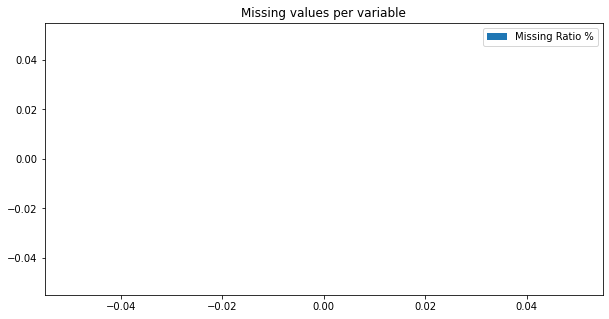

In [308]:
try:
  plot_missing_per_variable(df_aire_clustered_s) 
except IndexError:
  print("No NaN values found!")

In [309]:
df_aire_clustered_s.to_csv("pollution_cdmx.csv")
!ls

alcaldias.csv  mapa_mexico	meteorology.csv  pollution_cdmx.csv
df_aire.csv    mapa_mexico.zip	pollutants.csv	 sample_data


### Visualizations

To explore data and check for irregularities

In [311]:
import pandas as pd
from plotnine.data import mpg
from plotnine import ggplot, aes, geom_point, geom_bar, geom_boxplot, geom_hline, facet_grid, labs, geom_point, geom_col, stat_count, geom_histogram, stat_density, coord_flip
from plotnine import scale_x_continuous, scale_y_continuous, scale_colour_discrete, scale_x_reverse, scale_y_reverse, scale_color_manual, scale_color_brewer, scale_x_discrete, scale_fill_manual
from plotnine import theme_xkcd, theme_classic, theme_light, theme, element_blank
from plotnine import geom_text, position_stack

In [318]:
df = pd.read_csv("pollution_cdmx.csv", index_col=0)
df.dropna(inplace=True)
df.head()

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud
0,0,2018-01-01,0.447826,5.978261,22.391304,28.380435,26.713043,67.855072,19.165217,52.173913,20.376812,52.471014,13.300000,219.804348,2.285507,541.783926,-99.07388,19.360794
1,0,2018-01-02,0.561458,19.250000,29.416667,48.635417,22.166667,44.444444,4.000000,25.275000,20.791667,56.138889,13.013889,146.381944,1.496528,471.623188,-99.07388,19.360794
2,0,2018-01-03,0.767708,33.180060,42.272321,75.485119,24.758333,68.658730,6.671429,37.064286,32.678571,50.297619,14.631548,174.992063,1.615377,166.784886,-99.07388,19.360794
3,0,2018-01-04,0.601498,23.197917,41.496528,64.697917,23.941667,74.041667,34.469444,45.859524,27.851852,57.741733,13.011442,102.186177,1.535946,185.644324,-99.07388,19.360794
4,0,2018-01-05,0.660985,12.455492,40.351326,52.767045,36.082576,75.959596,5.171970,43.172727,33.946970,48.047348,16.272538,132.457071,1.624116,201.174001,-99.07388,19.360794


In [319]:
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.dayofyear
df['weekday'] = df['date'].dt.dayofweek
df.head()

,cluster,date,CO,NO,NO2,NOX,O3,PM10,SO2,PM2.5,PMCO,RH,TMP,WDR,WSP,PM10_var,longitud,latitud,day,weekday
0,0,2018-01-01,0.447826,5.978261,22.391304,28.380435,26.713043,67.855072,19.165217,52.173913,20.376812,52.471014,13.300000,219.804348,2.285507,541.783926,-99.07388,19.360794,1,0
1,0,2018-01-02,0.561458,19.250000,29.416667,48.635417,22.166667,44.444444,4.000000,25.275000,20.791667,56.138889,13.013889,146.381944,1.496528,471.623188,-99.07388,19.360794,2,1
2,0,2018-01-03,0.767708,33.180060,42.272321,75.485119,24.758333,68.658730,6.671429,37.064286,32.678571,50.297619,14.631548,174.992063,1.615377,166.784886,-99.07388,19.360794,3,2
3,0,2018-01-04,0.601498,23.197917,41.496528,64.697917,23.941667,74.041667,34.469444,45.859524,27.851852,57.741733,13.011442,102.186177,1.535946,185.644324,-99.07388,19.360794,4,3
4,0,2018-01-05,0.660985,12.455492,40.351326,52.767045,36.082576,75.959596,5.171970,43.172727,33.946970,48.047348,16.272538,132.457071,1.624116,201.174001,-99.07388,19.360794,5,4


In [322]:
{i: feat for i in features}

['CO',
 'NO',
 'NO2',
 'NOX',
 'O3',
 'PM10',
 'SO2',
 'PM2.5',
 'PMCO',
 'RH',
 'TMP',
 'WDR',
 'WSP',
 'PM10_var']

In [324]:
colors = np.array(*[sns.color_palette("hls",len(features))])*255
colors = ["#"+"".join([f'{hex(int(i))[2:]}0'[:2] for i in c]) for c in colors]

In [328]:
len(features)

14

In [331]:
plots = [
  ggplot(df) + aes(x=feature) + geom_histogram(color=colors[idx], fill=colors[idx])
  for idx, feature in enumerate(feature)
]

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 83'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


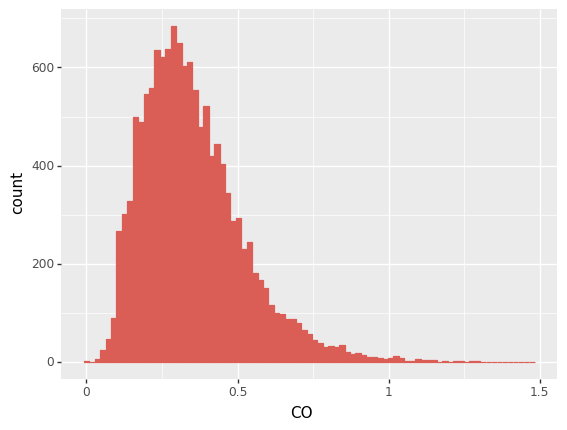

<ggplot: (8749439217949)>

In [335]:
ggplot(df) + aes(x="CO") + geom_histogram(color=colors[0], fill=colors[0])

/usr/local/lib/python3.7/dist-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 108'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


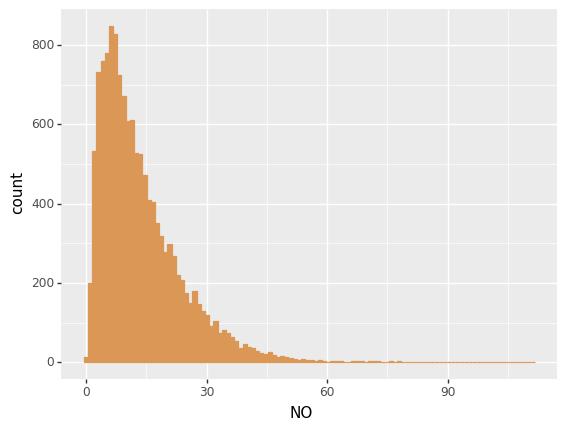

<ggplot: (8749439218865)>

In [336]:
ggplot(df) + aes(x="NO") + geom_histogram(color=colors[1], fill=colors[1])